In [1]:
### Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (train_test_split,StratifiedKFold,cross_val_score,GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report,roc_auc_score,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE



In [2]:
##load Data
data_path = "restaurant_customer_satisfaction.csv"
df = pd.read_csv(data_path)


In [3]:
#overlook data
df.describe()


,CustomerID,Age,Income,AverageSpend,GroupSize,OnlineReservation,DeliveryOrder,LoyaltyProgramMember,WaitTime,ServiceRating,FoodRating,AmbianceRating,HighSatisfaction
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,1403.500000,43.832000,85921.890000,105.659004,5.035333,0.296667,0.405333,0.480000,30.163550,3.044000,2.997333,2.987333,0.134000
std,433.157015,14.967157,38183.051749,52.381849,2.558864,0.456941,0.491120,0.499766,17.214184,1.423405,1.418920,1.450716,0.340766
min,654.000000,18.000000,20012.000000,10.306127,1.000000,0.000000,0.000000,0.000000,0.001380,1.000000,1.000000,1.000000,0.000000
25%,1028.750000,31.750000,52444.000000,62.287907,3.000000,0.000000,0.000000,0.000000,15.235423,2.000000,2.000000,2.000000,0.000000
50%,1403.500000,44.000000,85811.000000,104.626408,5.000000,0.000000,0.000000,0.000000,30.044055,3.000000,3.000000,3.000000,0.000000
75%,1778.250000,57.000000,119159.250000,148.649330,7.000000,1.000000,1.000000,1.000000,45.285649,4.000000,4.000000,4.000000,0.000000
max,2153.000000,69.000000,149875.000000,199.973526,9.000000,1.000000,1.000000,1.000000,59.970762,5.000000,5.000000,5.000000,1.000000


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerID            1500 non-null   int64  
 1   Age                   1500 non-null   int64  
 2   Gender                1500 non-null   object 
 3   Income                1500 non-null   int64  
 4   VisitFrequency        1500 non-null   object 
 5   AverageSpend          1500 non-null   float64
 6   PreferredCuisine      1500 non-null   object 
 7   TimeOfVisit           1500 non-null   object 
 8   GroupSize             1500 non-null   int64  
 9   DiningOccasion        1500 non-null   object 
 10  MealType              1500 non-null   object 
 11  OnlineReservation     1500 non-null   int64  
 12  DeliveryOrder         1500 non-null   int64  
 13  LoyaltyProgramMember  1500 non-null   int64  
 14  WaitTime              1500 non-null   float64
 15  ServiceRating        

In [5]:
df.head(5)

,CustomerID,Age,Gender,Income,VisitFrequency,AverageSpend,PreferredCuisine,TimeOfVisit,GroupSize,DiningOccasion,MealType,OnlineReservation,DeliveryOrder,LoyaltyProgramMember,WaitTime,ServiceRating,FoodRating,AmbianceRating,HighSatisfaction
0,654,35,Male,83380,Weekly,27.829142,Chinese,Breakfast,3,Business,Takeaway,0,1,1,43.523929,2,5,4,0
1,655,19,Male,43623,Rarely,115.408622,American,Dinner,1,Casual,Dine-in,0,0,0,57.524294,5,5,3,0
2,656,41,Female,83737,Weekly,106.693771,American,Dinner,6,Celebration,Dine-in,0,1,0,48.682623,3,4,5,0
3,657,43,Male,96768,Rarely,43.508508,Indian,Lunch,1,Celebration,Dine-in,0,0,0,7.552993,4,5,1,0
4,658,55,Female,67937,Monthly,148.084627,Chinese,Breakfast,1,Business,Takeaway,0,0,1,37.789041,2,3,5,0


In [6]:
df.drop(["CustomerID"], axis=1, inplace=True)

In [7]:
col_numerical = ["Age","Income","AverageSpend","WaitTime"]
col_categorical = ["Gender","VisitFrequency","PreferredCuisine","TimeOfVisit","DiningOccasion","MealType","OnlineReservation","DeliveryOrder","LoyaltyProgramMember"]
col_ordinal= ["GroupSize","ServiceRating","FoodRating","AmbianceRating"]

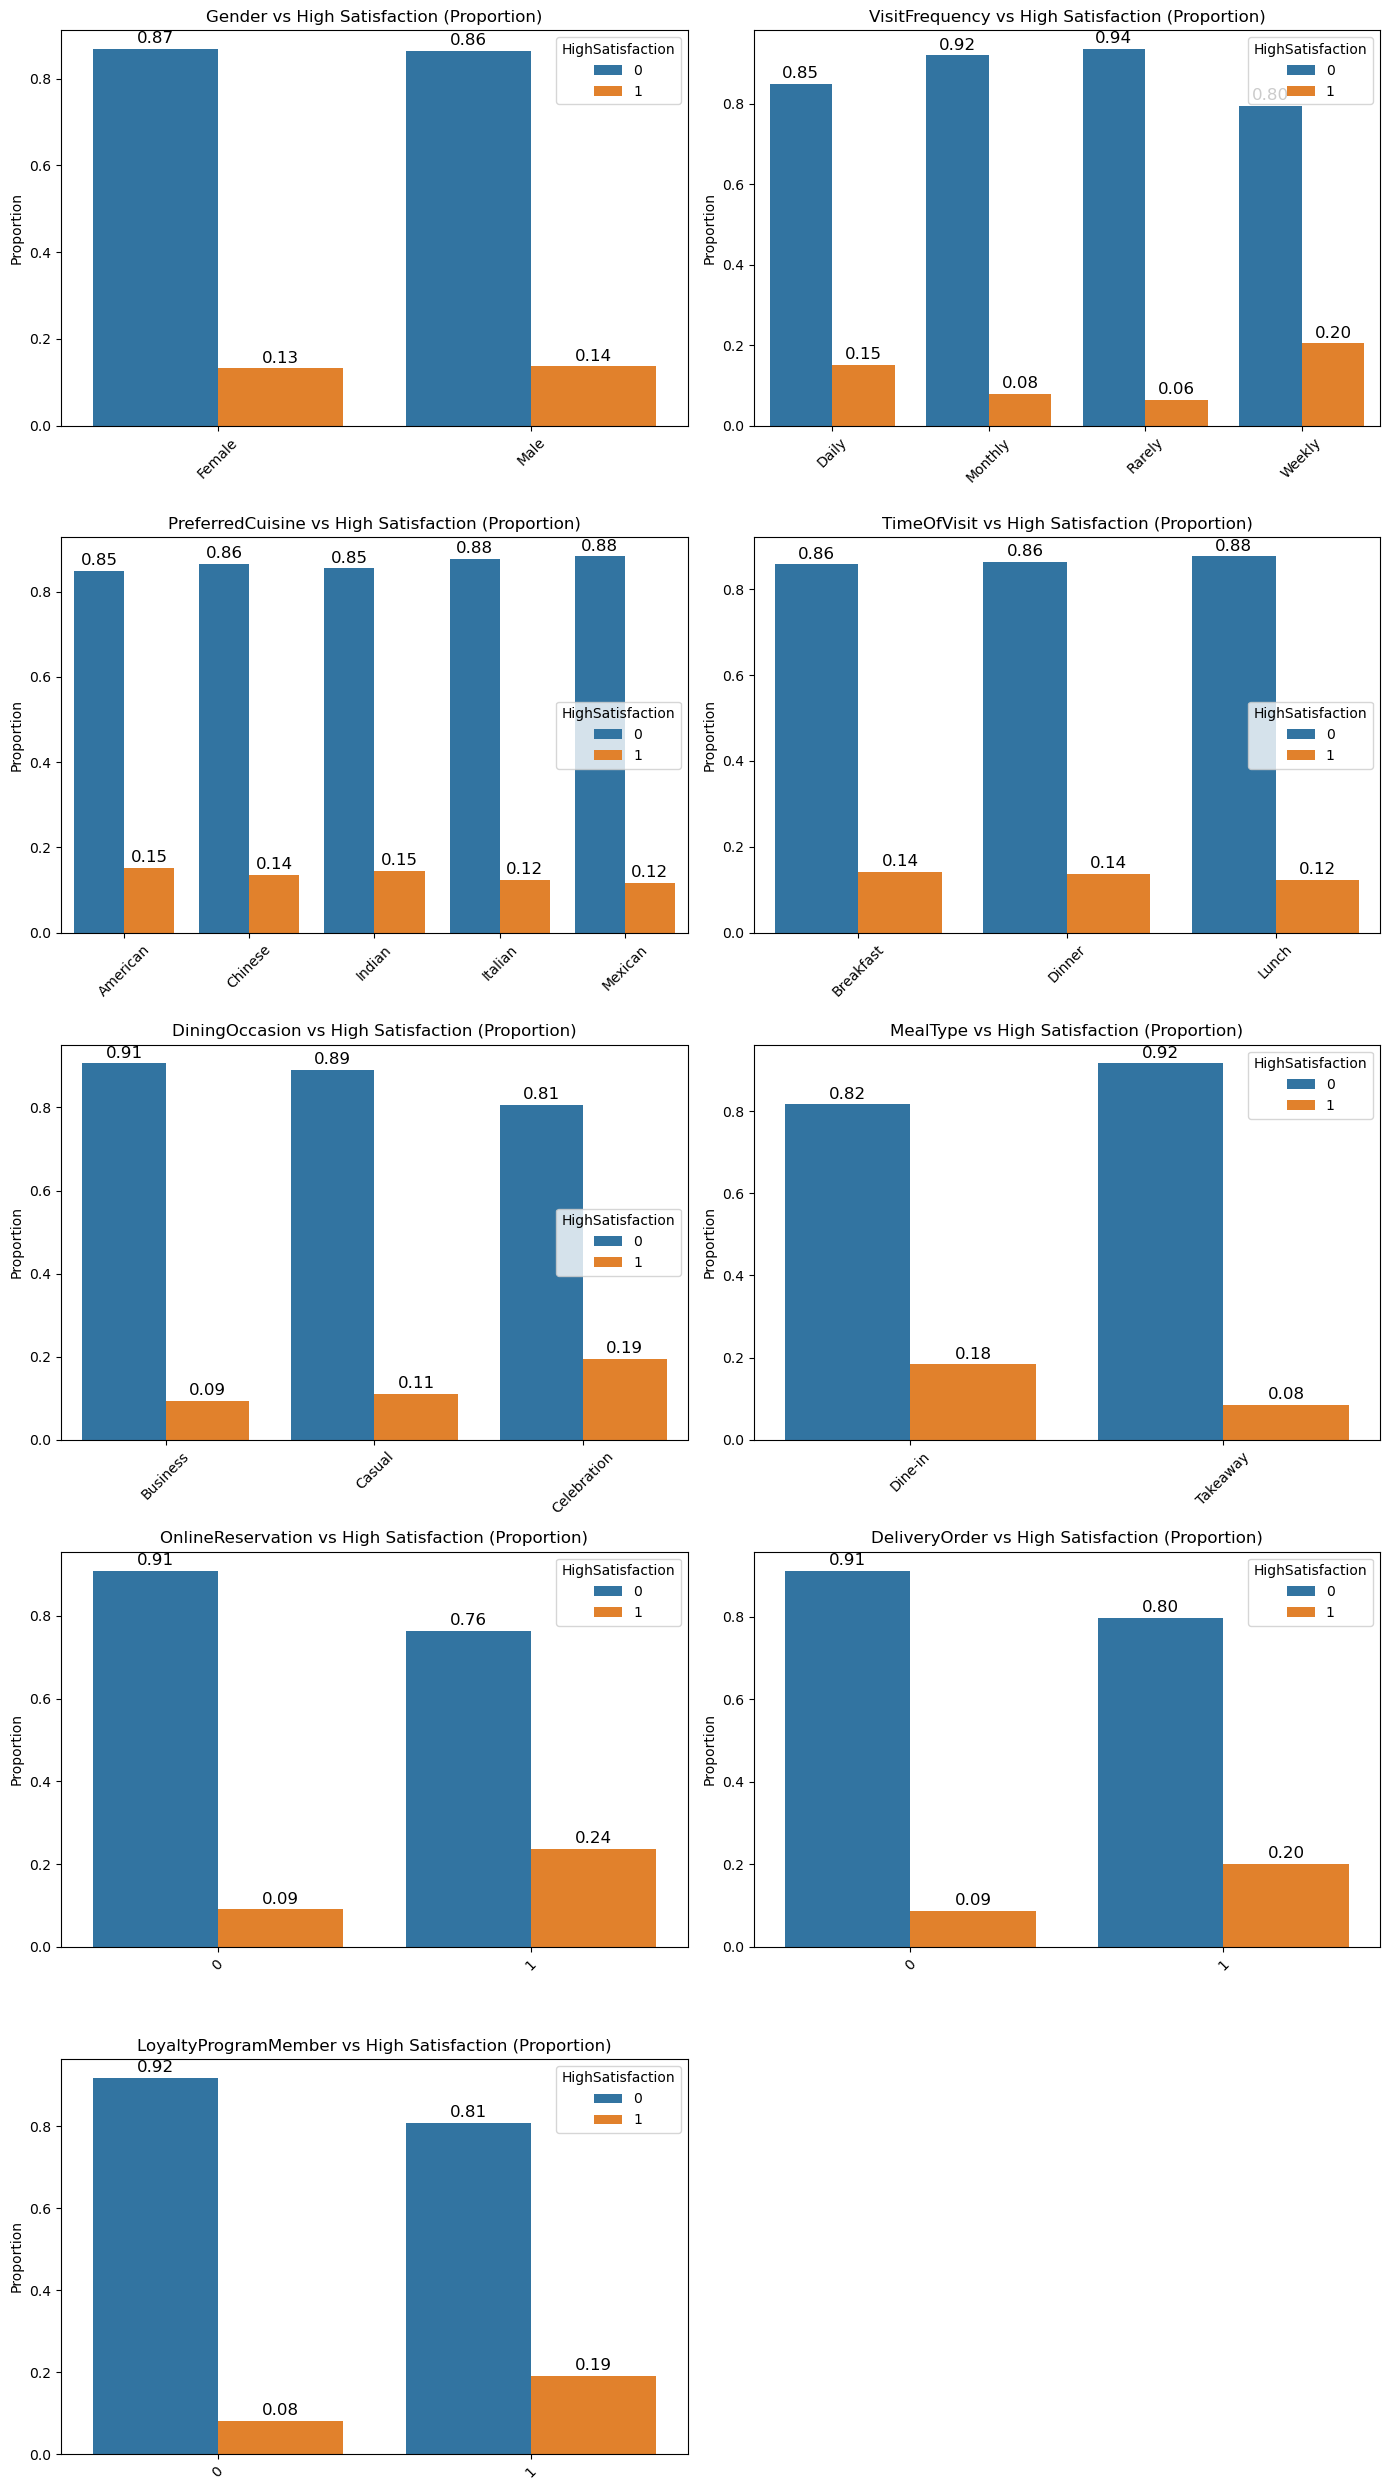

<Figure size 640x480 with 0 Axes>

In [8]:
### Categorical plot VS HighSatisfaction 
df_prop = df.copy()
proportion_data = []

for col in col_categorical:
    temp = df_prop.groupby([col, 'HighSatisfaction']).size().reset_index(name='count')
    total = temp.groupby(col)['count'].transform('sum')
    temp['proportion'] = temp['count'] / total
    temp['feature'] = col
    temp.rename(columns={col: 'category'}, inplace=True)
    proportion_data.append(temp)

prop_df = pd.concat(proportion_data)

#labels
num_cols = col_categorical
n_cols = 2
n_rows = (len(num_cols) + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))

axes = axes.flatten()

for i, col in enumerate(col_categorical):
    subset = prop_df[prop_df['feature'] == col]
    ax = axes[i]
    bars = sns.barplot(data=subset, x='category', y='proportion', hue='HighSatisfaction', ax=ax)
    ax.set_title(f'{col} vs High Satisfaction (Proportion)')
    ax.set_ylabel('Proportion')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

    # labels to bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=12, padding=2)

# Remove subplots
if len(col_categorical) < len(axes):
    for j in range(len(col_categorical), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
#plt.savefig("C:/Users/MAAP/Pictures/Proportionlplot.png")
plt.show()
plt.clf()

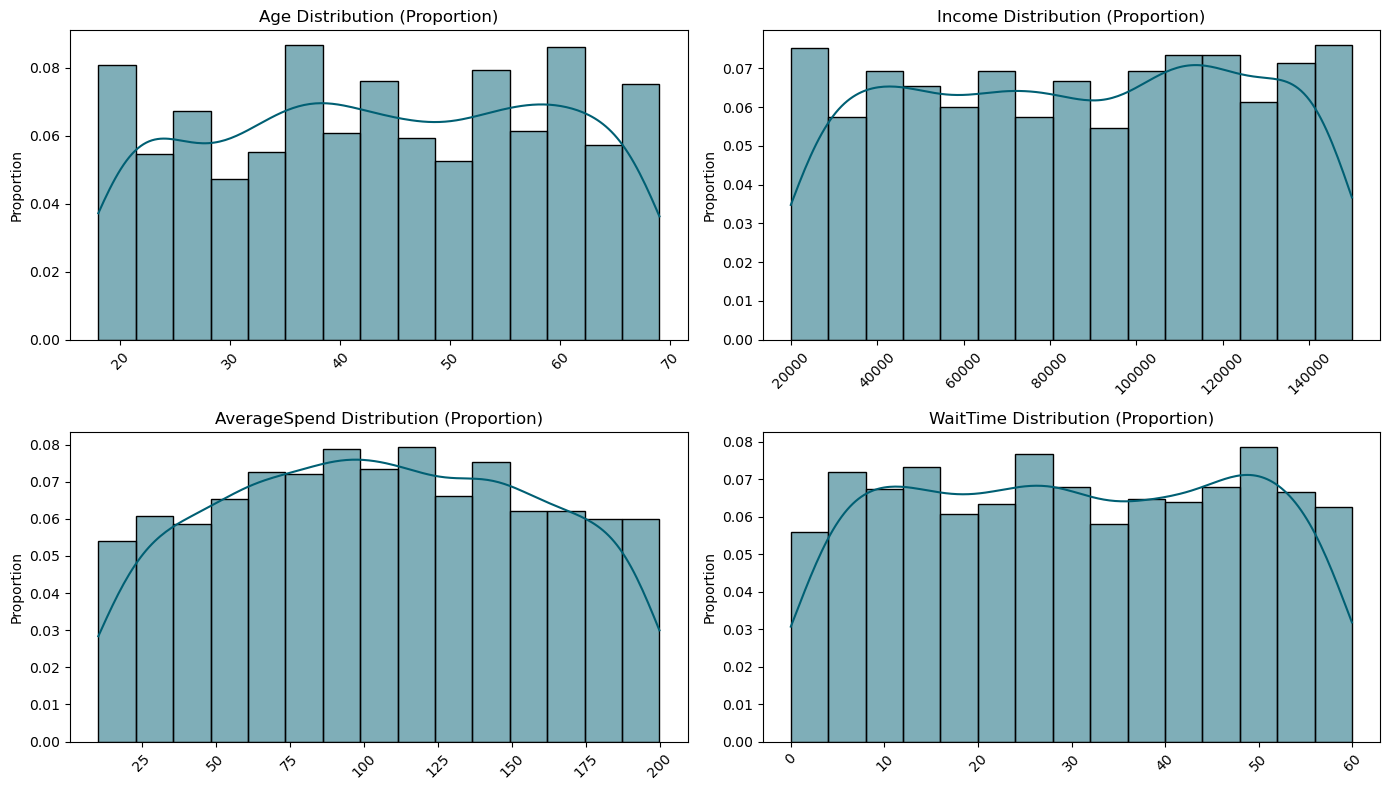

In [9]:
# plot numerical features

num_cols = col_numerical   

n_cols = 2
n_rows = (len(num_cols) + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, bins=15, ax=axes[i], color="#005f73", stat='probability')
    axes[i].set_title(f'{col} Distribution (Proportion)', fontsize=12)
    axes[i].set_ylabel('Proportion')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused axes
if len(num_cols) < len(axes):
    for j in range(len(num_cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
#plt.savefig("C:/Users/MAAP/Pictures/Continueslplot.png")
plt.show()

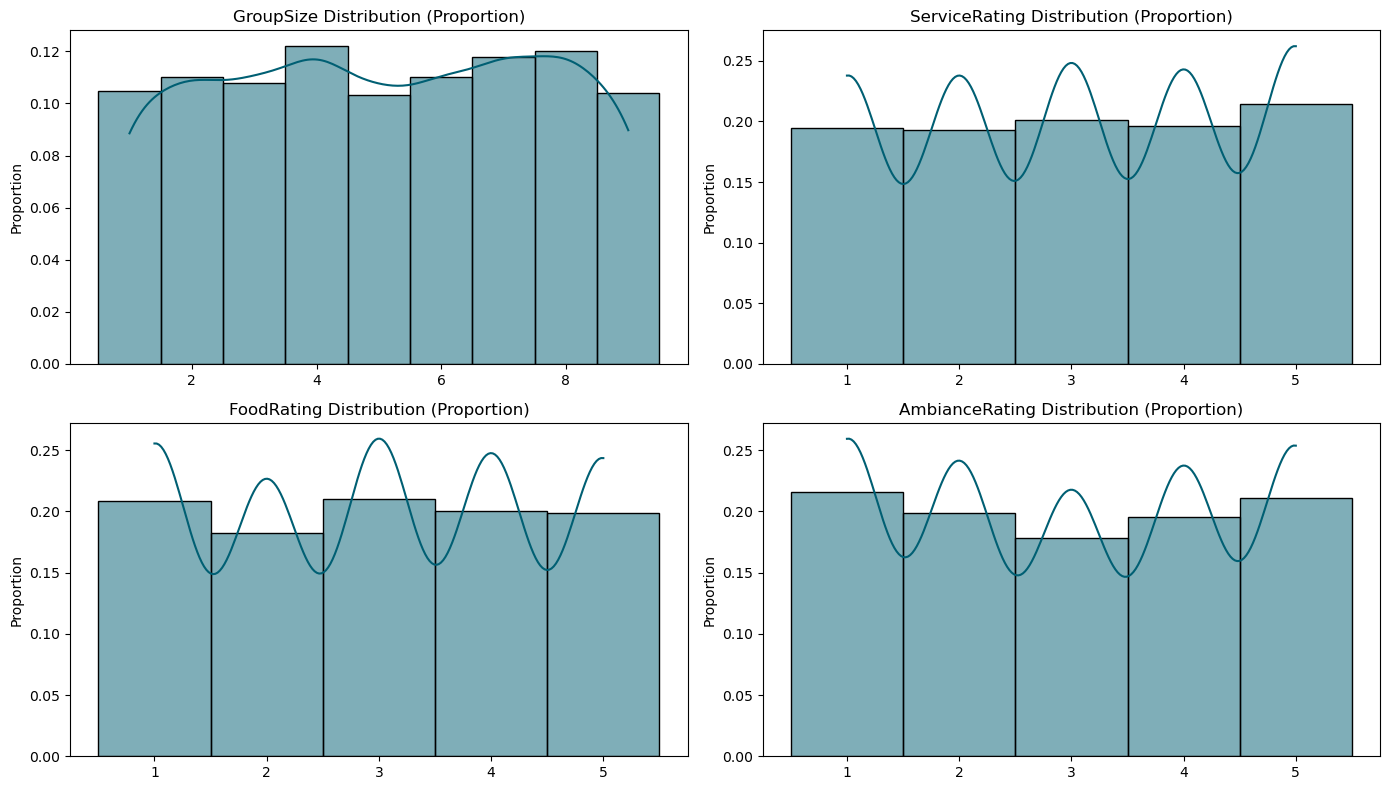

In [10]:
# plot ordinal

num_cols = col_ordinal  

n_cols = 2
n_rows = (len(num_cols) + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(
        data=df,
        x=col,
        kde=True,
        bins=5,
        ax=axes[i],
        color="#005f73",
        discrete=True,
        stat='probability'  # show proportion instead of count
    )
    axes[i].set_title(f'{col} Distribution (Proportion)', fontsize=12)
    axes[i].set_ylabel('Proportion')
    axes[i].set_xlabel('')
    
    axes[i].tick_params(axis='x', rotation=0)

# Remove unused axes
if len(num_cols) < len(axes):
    for j in range(len(num_cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
#plt.savefig("C:/Users/MAAP/Pictures/Discreteplot.png")
plt.show()


In [11]:
##chi-2test - https://www.geeksforgeeks.org/python-pearsons-chi-square-test/#performing-chisquare-test-in-python
chi_results = []

for feature in col_categorical:
    contingency_table = pd.crosstab(df[feature], df['HighSatisfaction'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_results.append({
        'Feature': feature,
        'Chi² Value': round(chi2, 2),
        'Degrees of Freedom': dof,
        'p-value': round(p, 5),
        'significant':  'significant' if p < 0.05 else 'insignificant'
    })

# Convert to DataFrame for display
chi_results_df = pd.DataFrame(chi_results)
chi_results_df = chi_results_df.sort_values(by='p-value')

# Print the results
print(chi_results_df)

                Feature  Chi² Value  Degrees of Freedom  p-value  \
1        VisitFrequency       50.63                   3  0.00000   
4        DiningOccasion       25.67                   2  0.00000   
5              MealType       31.23                   1  0.00000   
6     OnlineReservation       55.43                   1  0.00000   
7         DeliveryOrder       40.12                   1  0.00000   
8  LoyaltyProgramMember       38.73                   1  0.00000   
3           TimeOfVisit        0.80                   2  0.67154   
2      PreferredCuisine        2.15                   4  0.70907   
0                Gender        0.03                   1  0.85493   

     significant  
1    significant  
4    significant  
5    significant  
6    significant  
7    significant  
8    significant  
3  insignificant  
2  insignificant  
0  insignificant  


In [12]:
##prepare data for ML
encoded_df = pd.get_dummies(df, columns=col_categorical, drop_first=True)
#separate the data
X = encoded_df.drop("HighSatisfaction", axis=1) 
y = encoded_df["HighSatisfaction"] #target satisfy = 0 no-satisfy = 1
scalert =  StandardScaler()
X[col_numerical] =  scalert.fit_transform(X[col_numerical])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
"""
Naive Classifier
This is to know what the accuracy is for always choosen No == 0
"""

'\nNaive Classifier\nThis is to know what the accuracy is for always choosen No == 0\n'

In [14]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_dummy_pred = dummy_clf.predict(X_test)

# Evaluate its performance
print("=== Naive Classifier (Most Frequent) ===")
print(classification_report(y_test, y_dummy_pred))


=== Naive Classifier (Most Frequent) ===
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       260
           1       0.00      0.00      0.00        40

    accuracy                           0.87       300
   macro avg       0.43      0.50      0.46       300
weighted avg       0.75      0.87      0.80       300



C:\Users\MAAP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MAAP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MAAP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
#Model without SMOTE 

=== Decision Tree Evaluation ===
Confusion Matrix:
[[212  48]
 [ 29  11]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       260
           1       0.19      0.28      0.22        40

    accuracy                           0.74       300
   macro avg       0.53      0.55      0.53       300
weighted avg       0.79      0.74      0.76       300

ROC AUC Score: 0.5451923076923076


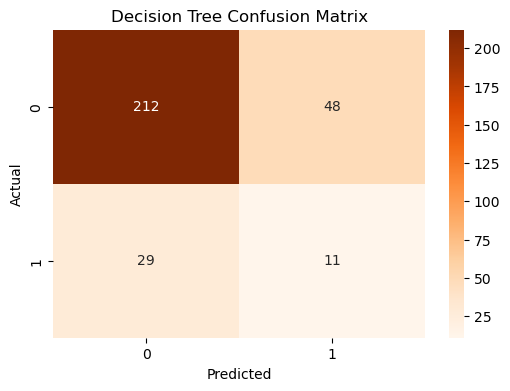


=== Random Forest Evaluation ===
Confusion Matrix:
[[260   0]
 [ 39   1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       260
           1       1.00      0.03      0.05        40

    accuracy                           0.87       300
   macro avg       0.93      0.51      0.49       300
weighted avg       0.89      0.87      0.81       300

ROC AUC Score: 0.7449038461538462


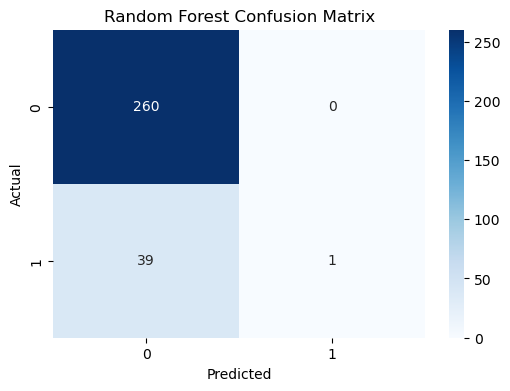

In [16]:
##https://www.kaggle.com/

#prepared Models, remember that 42 is just a number 
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

# k-Fold CV scores
dt_scores = cross_val_score(dt_model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
rf_scores = cross_val_score(rf_model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Decision Tree Evaluation
print("=== Decision Tree Evaluation ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
print("ROC AUC Score:", roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1]))

# Confusion matrix for Decision Tree
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Oranges')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Random Forest Evaluation
print("\n=== Random Forest Evaluation ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


# Confusion matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
#With SMOTE

In [18]:
sm = SMOTE(random_state=12)
X_train, y_train = sm.fit_resample(X_train, y_train)

=== Decision Tree whit SMOTE Evaluation ===
Confusion Matrix:
[[220  40]
 [ 20  20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       260
           1       0.33      0.50      0.40        40

    accuracy                           0.80       300
   macro avg       0.62      0.67      0.64       300
weighted avg       0.84      0.80      0.82       300

ROC AUC Score: 0.6724038461538462


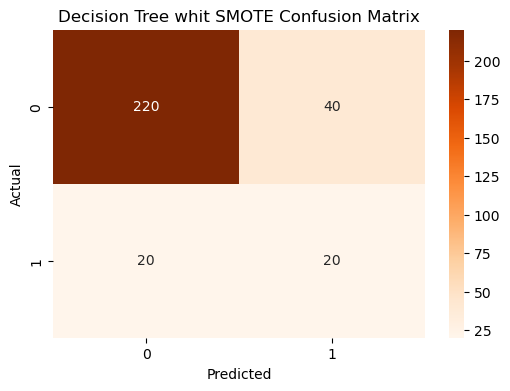


=== Random Forest with SMOTE Evaluation ===
Confusion Matrix:
[[255   5]
 [ 25  15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       260
           1       0.75      0.38      0.50        40

    accuracy                           0.90       300
   macro avg       0.83      0.68      0.72       300
weighted avg       0.89      0.90      0.89       300

ROC AUC Score: 0.7543269230769232


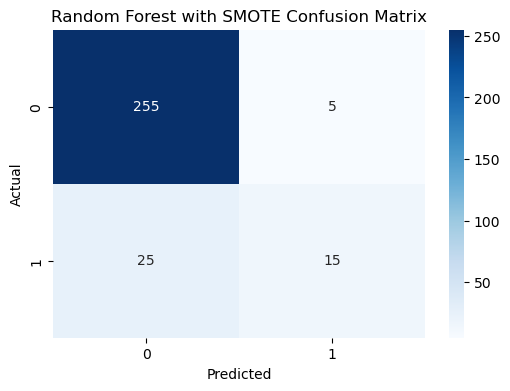

In [19]:
#prepared Models, remember that 42 is just a number 
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth= 15, min_samples_split = 10,random_state=42)
rf_model = RandomForestClassifier(criterion='entropy', max_depth= 15, min_samples_split = 2,random_state=42)

# k-Fold CV scores
dt_scores = cross_val_score(dt_model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
rf_scores = cross_val_score(rf_model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Decision Tree Evaluation
print("=== Decision Tree whit SMOTE Evaluation ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
print("ROC AUC Score:", roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1]))

# Confusion matrix for Decision Tree
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Oranges')
plt.title('Decision Tree whit SMOTE Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Random Forest Evaluation
print("\n=== Random Forest with SMOTE Evaluation ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


# Confusion matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest with SMOTE Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
"""Find the best criteria for the desicion Tree with GridSearchCV"""

'Find the best criteria for the desicion Tree with GridSearchCV'

In [21]:
#Set up hyperparameter grid
param_grid_dt = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

#Grid Search 
grid_search_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    #RandomForestClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# Fit model on SMOTE-balanced training data
grid_search_dt.fit(X_train, y_train)

# Use best model to predict
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

# Print evaluation metrics
print("Best Parameters:", grid_search_dt.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 10}
Accuracy: 0.8
Precision: 0.3333333333333333
Recall: 0.5
F1 Score: 0.4
ROC-AUC: 0.673076923076923
Confusion Matrix:
 [[220  40]
 [ 20  20]]


=== Decision Tree with Gred and SMOTE Evaluation ===
Confusion Matrix:
[[220  40]
 [ 20  20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       260
           1       0.33      0.50      0.40        40

    accuracy                           0.80       300
   macro avg       0.62      0.67      0.64       300
weighted avg       0.84      0.80      0.82       300

ROC AUC Score: 0.6724038461538462


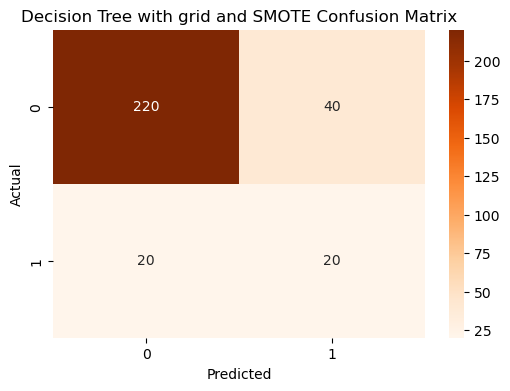


=== Random Forest with Gred and SMOTE Evaluation ===
Confusion Matrix:
[[255   5]
 [ 25  15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       260
           1       0.75      0.38      0.50        40

    accuracy                           0.90       300
   macro avg       0.83      0.68      0.72       300
weighted avg       0.89      0.90      0.89       300

ROC AUC Score: 0.7543269230769232


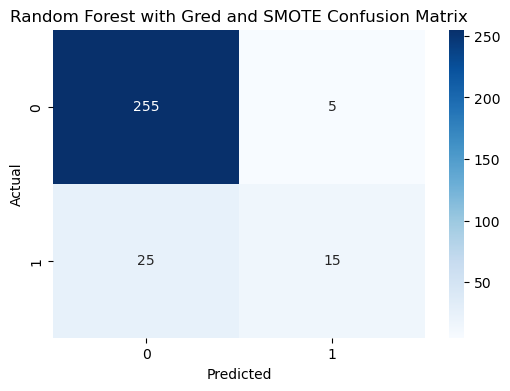

In [22]:
#prepared Models, remember that 42 is just a number 
dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=15,min_samples_split=10,random_state=42)##use the criterial for best performance of  GridSearchCV
rf_model = RandomForestClassifier(criterion='entropy', max_depth= 15, min_samples_split=2,random_state=42)##use the criterial for best performance of  GridSearchCV

# k-Fold CV scores
dt_scores = cross_val_score(dt_model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
rf_scores = cross_val_score(rf_model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Decision Tree Evaluation
print("=== Decision Tree with Gred and SMOTE Evaluation ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
print("ROC AUC Score:", roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1]))

# Confusion matrix for Decision Tree
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Oranges')
plt.title('Decision Tree with grid and SMOTE Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Random Forest Evaluation
print("\n=== Random Forest with Gred and SMOTE Evaluation ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


# Confusion matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest with Gred and SMOTE Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score



# Define selected features based on statistical tests
selected_features = [
    'VisitFrequency', 'DiningOccasion', 'MealType', 'OnlineReservation',
    'DeliveryOrder', 'LoyaltyProgramMember', 'ServiceRating', 'FoodRating',
    'AmbianceRating', 'GroupSize', 'WaitTime'
]

# Filter relevant columns
df_selected = df[selected_features + ['HighSatisfaction']]

# One-hot encode categorical features
categorical_features = ['VisitFrequency', 'DiningOccasion', 'MealType',
                        'OnlineReservation', 'DeliveryOrder', 'LoyaltyProgramMember']
df_encoded = pd.get_dummies(df_selected, columns=categorical_features, drop_first=True)

# Define X and y
X = df_encoded.drop(columns='HighSatisfaction')
y = df_encoded['HighSatisfaction']

# Scale numeric features
numeric_features = ['ServiceRating', 'FoodRating', 'AmbianceRating', 'GroupSize', 'WaitTime']
X[numeric_features] = StandardScaler().fit_transform(X[numeric_features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
sm = SMOTE(random_state=12)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Train models
dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=15,min_samples_split=10,random_state=42)##use the criterial for best performance of  GridSearchCV
rf_model = RandomForestClassifier(criterion='entropy', max_depth= 15, min_samples_split=2,random_state=42)##use the criterial for best performance of  GridSearchCV

dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("=== Decision Tree ===")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_pred_dt))

print("\n=== Random Forest ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf))


=== Decision Tree ===
[[225  35]
 [ 23  17]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       260
           1       0.33      0.42      0.37        40

    accuracy                           0.81       300
   macro avg       0.62      0.65      0.63       300
weighted avg       0.83      0.81      0.82       300

ROC AUC: 0.6451923076923077

=== Random Forest ===
[[247  13]
 [ 23  17]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       260
           1       0.57      0.42      0.49        40

    accuracy                           0.88       300
   macro avg       0.74      0.69      0.71       300
weighted avg       0.87      0.88      0.87       300

ROC AUC: 0.6875
